In [58]:
import pandas as pd 
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
class Point: 
  def __init__(self, x0: float, x1: float, variety: int) -> None: 
    self.x0 = x0
    self.x1 = x1 
    self.variety = variety 
  
  def __str__(self): 
    return f"[x0: {self.x0}, x1: {self.x1}, class: {self.variety}]"

In [60]:
def distance_metric_factory(metric: str): 
  distances = { 
      "euclidian" : euclidian_distance,
      "manhattan" : manhattan_distance, 
      "minkowski" : minkowski_distance,
  }

  return distances[metric]

def euclidian_distance (point_a: Point, point_b: Point) -> float:
  delta_x0 = (point_a.x0 - point_b.x0) ** 2
  delta_x1 = (point_a.x1 - point_b.x1) ** 2

  return (delta_x0 + delta_x1) ** (1/2)

def manhattan_distance (point_a: Point, point_b: Point) -> float:
  delta_x0 = abs((point_a.x0 - point_b.x0)) 
  delta_x1 = abs((point_a.x1 - point_b.x1)) 

  return abs(delta_x0 + delta_x1)

def minkowski_distance (point_a: Point, point_b: Point) -> float:
  delta_x0 = abs((point_a.x0 - point_b.x0)) 
  delta_x1 = abs((point_a.x1 - point_b.x1))  

  return abs(delta_x0 + delta_x1)**0.666

In [61]:
class Knn: 
  def __init__(self, distance_func, K: int, varieties_localizer: dict) -> None:
    self.get_distance = distance_func
    self.K = K
    self.varieties_localizer = varieties_localizer

  def fit(self, X, y) -> None:
    self.points = [] 

    for x, y in list(zip(X, y)):
      point = Point(x[0], x[1], y) 
      self.points.append(point)
    
  
  def predict(self, point: Point) -> str: 
    close_points = self.get_close_points(point)
    dominant_variety = self.find_dominant_variety(close_points)

    return dominant_variety

  def get_close_points(self, point:Point) -> list: 
    distances = []
    for p in self.points: 
      distance = self.get_distance(p, point) 
      distances.append([distance, p.variety]) 

    close_points = sorted(distances)[:self.K]

    return close_points
  
  def find_dominant_variety(self, close_points: list) -> int:
    appearances = []
    for point in close_points: 
      appearances.append(point[1])

    varieties = self.varieties_localizer.keys() 
    scores = {}
    for var in varieties: 
      scores[var] = appearances.count(int(var)) 

    return sorted(scores, reverse=True, key=scores.get)[0]

In [62]:
varieties_localizer = {
    "0": "setosa", 
    "1": "versicolor",
    "2": "virginica"
}

In [63]:
dataset = load_iris()
# Normaliza os dados para um intevalo de -1 a 1 
X = dataset["data"]
X = StandardScaler().fit_transform(X) 

In [64]:
# Realiza PCA para cada dimensão do conjunto de dados
N_COMPONENTS = 4

pca = PCA(n_components=N_COMPONENTS)
pc_components = pca.fit_transform(X)

pcas_variation = pca.explained_variance_ratio_

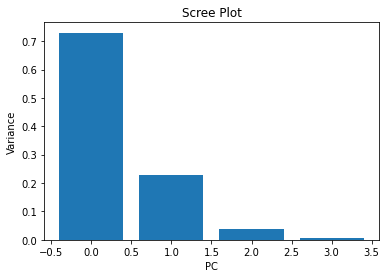

In [65]:
plt.bar(x=range(N_COMPONENTS) , height=pcas_variation)
plt.ylabel("Variance")
plt.xlabel("PC")
plt.title("Scree Plot")
plt.show()

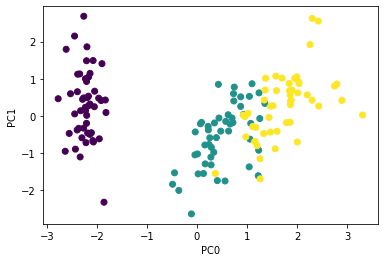

A variação total de PC0 e PC1 é 0.9581320720000165



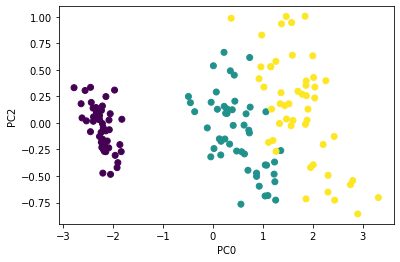

A variação total de PC0 e PC2 é 0.7663136730258274


In [100]:
pc0 = pc_components[:, 0]
pc1 = pc_components[:, 1]
pc2 = pc_components[:, 2]
labels = dataset['target']

# Plot para PC1 e PC2
plt.scatter(pc0, pc1, c=labels)
plt.ylabel("PC1")
plt.xlabel("PC0")
plt.show()
print(f"A variação total de PC0 e PC1 é {pcas_variation[0]+ pcas_variation[1]}")

print("")

# Plot para PC0 e PC2
plt.scatter(pc0, pc2, c=labels)
plt.ylabel("PC2")
plt.xlabel("PC0")
plt.show()

print(f"A variação total de PC0 e PC2 é {pcas_variation[0]+ pcas_variation[2]}")

In [101]:
# Cria conjunto de dados usando PC0 e PC2
X = np.array(list(zip(pc0,pc2)))
x_train, x_test, y_train, y_test = train_test_split(X, dataset["target"], test_size=0.33, random_state=0)

In [102]:
d = distance_metric_factory(metric="minkowski")
k = Knn(d, K=5, varieties_localizer=varieties_localizer)
k.fit(x_train, y_train)

In [97]:
# Create a Point for each test case
predictions = [] 
for x, y in list(zip(x_test, y_test)):
    point = Point(x[0], x[1], y) 
    predictions.append(point)


# Predict each point and makes and np.array of the results
y_pred = []
for point in predictions: 
  pred = k.predict(point) 
  y_pred.append(int(pred))

y_pred = np.array(y_pred)

In [98]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

confusion_matrix_localizer = pd.DataFrame(confusion_matrix,
                            index=['SETOSA','VERSICOLR','VIRGINICA'], 
                            columns=['SETOSA','VERSICOLR','VIRGINICA'])

A acurácia do modelo é de 94.0%


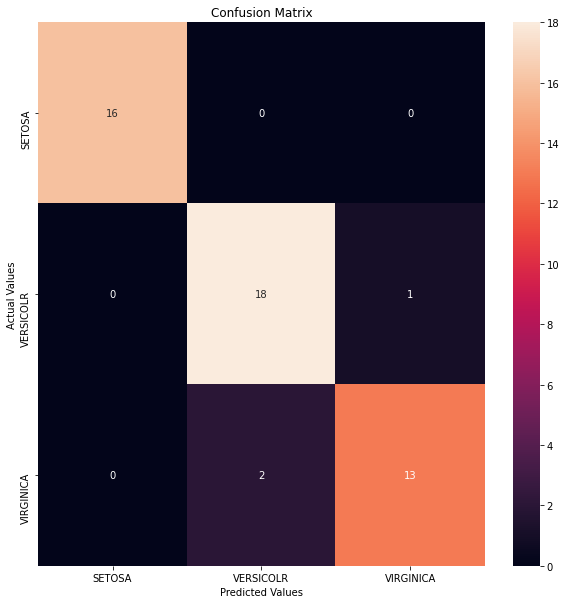

In [99]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix_localizer, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
print(f"A acurácia do modelo é de {accuracy*100}%")
plt.show()